In [2]:
import yfinance as yf
import pandas as pd
import time
from datetime import datetime
import matplotlib.pyplot as plt
import squarify
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib.patheffects import withStroke

# OMXS30 tickers information
omxs30_info = [
    {"SymbolYahoo": "ATCO-A.ST", "BaseSymbol": "ATCO", "Sector": "Industrials"},
    {"SymbolYahoo": "ATCO-B.ST", "BaseSymbol": "ATCO", "Sector": "Industrials"},
    {"SymbolYahoo": "ABB.ST",    "BaseSymbol": "ABB",  "Sector": "Industrials"},
    {"SymbolYahoo": "AZN.ST",    "BaseSymbol": "AZN",  "Sector": "Healthcare"},
    {"SymbolYahoo": "INVE-B.ST", "BaseSymbol": "INVE", "Sector": "Financials"},
    {"SymbolYahoo": "VOLV-B.ST", "BaseSymbol": "VOLV", "Sector": "Industrials"},
    {"SymbolYahoo": "NDA-SE.ST", "BaseSymbol": "NDA",  "Sector": "Financials"},
    {"SymbolYahoo": "ASSA-B.ST", "BaseSymbol": "ASSA", "Sector": "Industrials"},
    {"SymbolYahoo": "SEB-A.ST",  "BaseSymbol": "SEB",  "Sector": "Financials"},
    {"SymbolYahoo": "ERIC-B.ST", "BaseSymbol": "ERIC", "Sector": "Technology"},
    {"SymbolYahoo": "HEXA-B.ST", "BaseSymbol": "HEXA", "Sector": "Technology"},
    {"SymbolYahoo": "SWED-A.ST", "BaseSymbol": "SWED", "Sector": "Financials"},
    {"SymbolYahoo": "SAND.ST",   "BaseSymbol": "SAND", "Sector": "Industrials"},
    {"SymbolYahoo": "SHB-A.ST",  "BaseSymbol": "SHB",  "Sector": "Financials"},
    {"SymbolYahoo": "HM-B.ST",   "BaseSymbol": "HM",   "Sector": "Consumer Discretionary"},
    {"SymbolYahoo": "ESSITY-B.ST","BaseSymbol": "ESSITY","Sector": "Consumer Staples"},
    {"SymbolYahoo": "ALFA.ST",   "BaseSymbol": "ALFA", "Sector": "Industrials"},
    {"SymbolYahoo": "EVO.ST",    "BaseSymbol": "EVO",  "Sector": "Technology"},
    {"SymbolYahoo": "SAAB-B.ST", "BaseSymbol": "SAAB", "Sector": "Industrials"},
    {"SymbolYahoo": "TELIA.ST",  "BaseSymbol": "TELIA","Sector": "Communication Services"},
    {"SymbolYahoo": "SKF-B.ST",  "BaseSymbol": "SKF",  "Sector": "Industrials"},
    {"SymbolYahoo": "SCA-B.ST",  "BaseSymbol": "SCA",  "Sector": "Materials"},
    {"SymbolYahoo": "BOL.ST",    "BaseSymbol": "BOL",  "Sector": "Materials"},
    {"SymbolYahoo": "NIBE-B.ST", "BaseSymbol": "NIBE", "Sector": "Industrials"},
    {"SymbolYahoo": "TEL2-B.ST", "BaseSymbol": "TEL2", "Sector": "Communication Services"},
    {"SymbolYahoo": "GETI-B.ST", "BaseSymbol": "GETI", "Sector": "Healthcare"},
    {"SymbolYahoo": "ELUX-B.ST", "BaseSymbol": "ELUX", "Sector": "Consumer Discretionary"},
    {"SymbolYahoo": "KINV-B.ST", "BaseSymbol": "KINV", "Sector": "Financials"},
    {"SymbolYahoo": "SINCH.ST",  "BaseSymbol": "SINCH","Sector": "Technology"},
    {"SymbolYahoo": "SBB-B.ST",  "BaseSymbol": "SBB",  "Sector": "Real Estate"}
]


# Step 1: Fetch data and calculate market capitalization
data = []

for symbol in [info["SymbolYahoo"] for info in omxs30_info]:
    try:
        print(f"Fetching data for {symbol}...")
        stock = yf.Ticker(symbol)
        info = stock.info  # Retrieve company information
        
        # Extract market cap and daily percentage change
        market_cap = info.get("marketCap", None)  # Market capitalization
        stock_data = yf.download(symbol, period="5d", interval="1d", progress=False)
        
        if len(stock_data) >= 2:
            stock_data = stock_data.tail(2)
            close_today = stock_data["Close"].iloc[-1]
            close_yesterday = stock_data["Close"].iloc[-2]
            pct_change = ((close_today - close_yesterday) / close_yesterday) * 100
        else:
            close_today = close_yesterday = pct_change = None

        data.append({
            "Symbol": symbol,
            "MarketCap": market_cap,
            "CloseToday": close_today,
            "CloseYesterday": close_yesterday,
            "PctChange": pct_change
        })
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        data.append({
            "Symbol": symbol,
            "MarketCap": None,
            "CloseToday": None,
            "CloseYesterday": None,
            "PctChange": None
        })

    time.sleep(1)  # Rate limiting to avoid issues with Yahoo Finance API

df_pct_change = pd.DataFrame(data)

# Step 2: Merge `df_pct_change` with `omxs30_info`
df_info = pd.DataFrame(omxs30_info)
df_combined = pd.merge(df_info, df_pct_change, left_on="SymbolYahoo", right_on="Symbol", how="left")

# Step 3: Assign MarketCap and WeightedDailyChange
df_combined["SumMarketCap"] = df_combined["MarketCap"]
df_combined["WeightedDailyChange"] = df_combined["PctChange"]

# Step 4: Combine duplicate companies (e.g., ATCO-A and ATCO-B)
# Group by `BaseSymbol` and `Sector`, then aggregate `SumMarketCap` and `WeightedDailyChange`
df_combined = (
    df_combined
    .groupby(["BaseSymbol", "Sector"], as_index=False)
    .agg({
        "SumMarketCap": "sum",  # Sum market caps
        "WeightedDailyChange": "mean",  # Average percentage change
    })
)

# Print the updated DataFrame
print(df_combined)


Fetching data for INVE-B.ST...
Fetching data for VOLV-B.ST...
Fetching data for NDA-SE.ST...
Fetching data for ASSA-B.ST...
Fetching data for SEB-A.ST...
Fetching data for ERIC-B.ST...
Fetching data for HEXA-B.ST...
Fetching data for SWED-A.ST...
Fetching data for SAND.ST...
Fetching data for SHB-A.ST...
Fetching data for HM-B.ST...
Fetching data for ESSITY-B.ST...
Fetching data for ALFA.ST...
Fetching data for EVO.ST...
Fetching data for SAAB-B.ST...
Fetching data for TELIA.ST...
Fetching data for SKF-B.ST...
Fetching data for SCA-B.ST...
Fetching data for BOL.ST...
Fetching data for NIBE-B.ST...
Fetching data for TEL2-B.ST...
Fetching data for GETI-B.ST...
Fetching data for ELUX-B.ST...
Fetching data for KINV-B.ST...
Fetching data for SINCH.ST...
Fetching data for SBB-B.ST...
   BaseSymbol                  Sector   SumMarketCap  WeightedDailyChange
0         ABB             Industrials  1198403092480             3.865817
1        ALFA             Industrials   201000435712           

In [3]:
# Step 3: Simulate MarketCap and WeightedDailyChange for demonstration purposes
print(df_combined.columns)

Index(['BaseSymbol', 'Sector', 'SumMarketCap', 'WeightedDailyChange'], dtype='object')


## Fixing heatmap size for each company

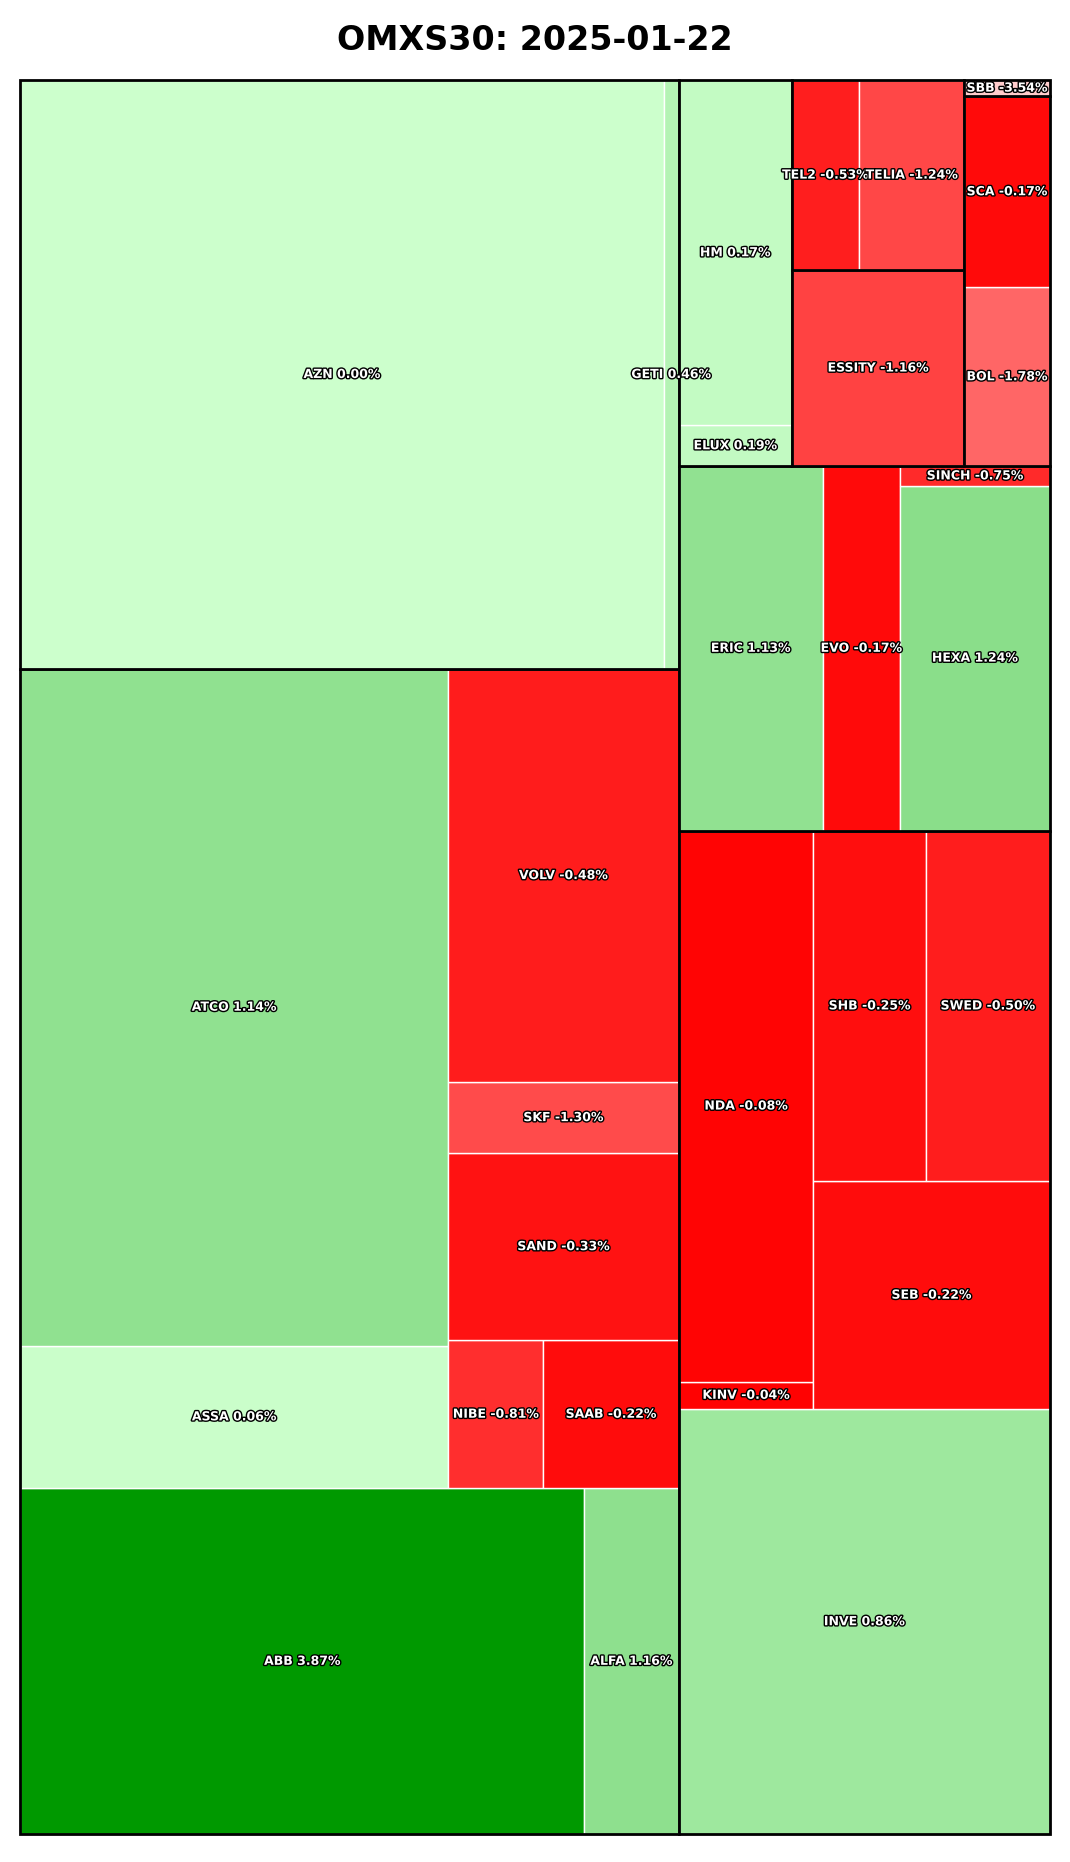

In [4]:
def plot_omxs30_treemap_instagram(df_combined):
    """
    Create a treemap where each company's area is proportional to its market capitalization.
    """
    # Aggregate sector market caps for top-level rectangles
    sector_agg = (
        df_combined
        .groupby("Sector", as_index=False)["SumMarketCap"]
        .sum()
        .rename(columns={"SumMarketCap": "TotalSectorMcap"})
        .sort_values("TotalSectorMcap", ascending=False)
    )

    # Normalize sector sizes to fit within the plot bounds
    total_market_cap = sector_agg["TotalSectorMcap"].sum()
    sector_sizes = sector_agg["TotalSectorMcap"].values / total_market_cap * (100 * 100)
    sector_names = sector_agg["Sector"].values
    sector_rects = squarify.squarify(sector_sizes, 0, 0, 100, 100)

    # Find min and max change for coloring
    min_chg = df_combined["WeightedDailyChange"].min()
    max_chg = df_combined["WeightedDailyChange"].max()

    # Two custom gradients: red-ish for negative, green-ish for positive
    light_red_to_red = LinearSegmentedColormap.from_list(
        "light_red_to_red", ["#FFCCCC", "#FF0000"]
    )
    light_green_to_strong_green = LinearSegmentedColormap.from_list(
        "light_green_to_strong_green", ["#CCFFCC", "#009900"]
    )

    # Normalizers for negative and positive changes
    norm_neg = mcolors.Normalize(vmin=min_chg, vmax=0)
    norm_pos = mcolors.Normalize(vmin=0, vmax=max_chg)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10.8, 19.2))  # Square figure for balanced treemap

    # Add margins
    margin = 1
    ax.set_xlim(-margin, 100 + margin)
    ax.set_ylim(-margin, 103 + margin)
    ax.axis("off")

    # Main loop: each sector is subdivided into stocks
    for srect, sector_name in zip(sector_rects, sector_names):
        subdf = df_combined[df_combined["Sector"] == sector_name]

        # Normalize company sizes within the sector to fit its allocated area
        sub_total_market_cap = subdf["SumMarketCap"].sum()
        sub_sizes = subdf["SumMarketCap"].values / sub_total_market_cap * (srect["dx"] * srect["dy"])
        sub_rects = squarify.squarify(
            sub_sizes, srect["x"], srect["y"], srect["dx"], srect["dy"]
        )

        # Plot each stock rectangle
        for sbox, row in zip(sub_rects, subdf.itertuples()):
            chg_val = row.WeightedDailyChange
            # Decide which colormap (negative or positive)
            if chg_val >= 0:
                color_rgba = light_green_to_strong_green(norm_pos(chg_val))
            else:
                color_rgba = light_red_to_red(norm_neg(chg_val))

            # Draw rectangle
            ax.add_patch(
                plt.Rectangle(
                    (sbox["x"], sbox["y"]), sbox["dx"], sbox["dy"],
                    facecolor=color_rgba, edgecolor="white"
                )
            )

            # Only add label if area is large enough
            if sbox["dx"] * sbox["dy"] > 2:  # Threshold for small areas
                sym = row.BaseSymbol
                label_str = f"{sym} {chg_val:.2f}%"
                ax.text(
                    sbox["x"] + sbox["dx"] / 2,
                    sbox["y"] + sbox["dy"] / 2,
                    label_str,
                    ha="center", va="center",
                    fontsize=10, fontweight="bold",
                    color="white",
                    path_effects=[withStroke(linewidth=2, foreground="black")]
                )

        # Draw sector-level bounding box with uniform line width
        ax.add_patch(
            plt.Rectangle(
                (srect["x"], srect["y"]),
                srect["dx"],
                srect["dy"],
                fill=False,
                edgecolor="black",
                linewidth=2
            )
        )

    # Add title and control its position
    fig.suptitle(
        f"OMXS30: {datetime.now().strftime('%Y-%m-%d')}",
        fontsize=24, fontweight="bold", y=0.96  # Use `y` to control vertical position
    )


    # Save and show plot
    plt.tight_layout()
    plt.savefig('OMXS30_HeatMap_daily.png', dpi=800, bbox_inches="tight")
    plt.show()
plot_omxs30_treemap_instagram(df_combined)